# Imputación de Valores Nulos en Conjuntos de Datos

En esta notebook, exploraremos diversas técnicas para la imputación de valores nulos en conjuntos de datos. La imputación de valores nulos es un paso crítico en la limpieza de datos, ya que los valores faltantes pueden afectar el rendimiento de los modelos de aprendizaje automático y el análisis de los datos. Utilizaremos datasets sintéticos y el dataset de Iris para demostrar diferentes métodos de imputación.

Primero, importamos las librerías necesarias y configuramos algunas variables iniciales.


In [41]:
# Importar librerías necesarias
import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from copy import copy

# Generación de Datos Sintéticos

Para esta práctica, generamos varios conjuntos de datos sintéticos con diferentes características. Estos conjuntos de datos nos permitirán ver cómo funcionan las diferentes técnicas de imputación en distintos contextos. Cada conjunto de datos tiene una estructura específica que nos ayudará a entender mejor los métodos de imputación.

Los datasets generados son:
1. **Dataset 0:** Datos generados aleatoriamente.
2. **Dataset 1:** Variables independientes lineales.
3. **Dataset 2:** Variables dependientes lineales.
4. **Dataset 3:** Variables dependientes no lineales.
5. **Dataset 4:** Dataset Iris.


### Configuraciones iniciales

In [2]:
PLOT = True
PLOT_PAIR = False
NUMERICAL = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
TARGET = ['Species']
test_split = .15
missing_ratio = .2

### Funciones comunes

In [3]:

def impute_column(df, col_to_predict, feature_columns):
    """Imputar valores faltantes de una columna a partir de un
       modelo LR sobre columnas restantes
    """
    nan_rows = np.where(np.isnan(df[col_to_predict]))
    all_rows = np.arange(0, len(df))
    train_rows_idx = np.argwhere(~np.isin(all_rows, nan_rows)).ravel()
    pred_rows_idx = np.argwhere(np.isin(all_rows, nan_rows)).ravel()

    X_train, y_train = df[feature_columns].iloc[train_rows_idx], df[col_to_predict].iloc[train_rows_idx]
    X_pred = df[feature_columns].iloc[pred_rows_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    df.loc[pred_rows_idx, col_to_predict] = model.predict(X_pred)
    return df



### Generación de los datos 

In [4]:
sd_factor = 1
mu_factor = 3
sd_min = 0.3
mu_min = 3
mu = np.array([[1, 2, 3, 4], [5, 6, 6, 3], [1, 3, 5, -2]])
sd = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]])
coef = [0.3, 1.2, 3]
n_samples = 150
targets = np.floor(np.linspace(0, 3 - 1 / n_samples, n_samples))[..., None]
columns = [
    'SepalLengthCm',
    'SepalWidthCm',
    'PetalLengthCm',
    'PetalWidthCm',
    'Species',
]



In [40]:
np.array([targets == t]).ravel()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Dataset 0: Random

In [7]:
d = []
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
for i, t in enumerate(np.unique(targets)):
    for j in range(len(d)):
        mask = np.array([targets == t]).ravel()
        len_ = np.sum(mask)
        d[j][mask] = sd[i, j] * np.random.randn(len_, 1) + mu[i, j]
data = np.concatenate((d[0], d[1], d[2], d[3], targets,), axis=1)
df1 = pd.DataFrame(data)



### Dataset 1: Linear independent

In [6]:
mu0 = np.random.rand(4) * mu_factor + mu_min
sd0 = np.random.rand(4) * sd_factor + sd_min
d = []
d.append(sd0[0] * np.random.randn(n_samples, 1) + mu0[0])
d.append(sd0[1] * np.random.randn(n_samples, 1) + mu0[1])
d.append(sd0[2] * np.random.randn(n_samples, 1) + mu0[2])
d.append(sd0[3] * np.random.rand(n_samples, 1) + mu0[3])
data = np.concatenate((d[0], d[1], d[2], d[3], targets,), axis=1)
df0 = pd.DataFrame(data)

### Dataset 2: Linear dependent

In [8]:
d = []
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
for i, t in enumerate(np.unique(targets)):
    for j in range(len(d) - 1):
        mask = np.array([targets == t]).ravel()
        len_ = np.sum(mask)
        d[j][mask] = sd[i, j] * np.random.randn(len_, 1) + mu[i, j]
d[-1] = np.zeros((n_samples, 1,))
for i in range(len(d) - 1):
    d[-1] += d[i] * coef[i]
data = np.concatenate((d[0], d[1], d[2], d[3], targets,), axis=1)
df2 = pd.DataFrame(data)

### Dataset 3: Non-linear dependent

In [9]:
d = []
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
d.append(np.zeros((n_samples, 1,)) * np.nan)
for i, t in enumerate(np.unique(targets)):
    for j in range(len(d) - 2):
        mask = np.array([targets == t]).ravel()
        len_ = np.sum(mask)
        d[j][mask] = sd[i, j] * np.random.randn(len_, 1) + mu[i, j]
d[-1] = np.array(d[0]) ** 2 + sd[0, 2] * np.random.randn(n_samples, 1) + mu[0, 2]
d[-2] = 3 / (np.abs(d[1] - np.mean(d[1]) + 0.2)) + sd[0, 3] * np.random.randn(n_samples, 1) + mu[0, 3]
data = np.concatenate((d[0], d[1], d[2], d[3], targets,), axis=1)
df3 = pd.DataFrame(data)

### Dataset 4: Iris dataset

In [10]:
iris = datasets.load_iris()
df_iris = np.concatenate((iris.data, iris.target[..., None],), axis=1)
df_iris = pd.DataFrame(df_iris)

# Análisis Exploratorio

Antes de proceder con la imputación de valores nulos, realizamos un análisis exploratorio de los conjuntos de datos generados. Este análisis incluye la visualización de las primeras filas de cada dataset y la generación de pairplots para observar la relación entre las variables.

Este paso nos ayuda a entender mejor la estructura de los datos y a identificar posibles patrones que podrían influir en la imputación.


Dataset 0
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0       2.914499      5.906553       5.421846      3.918547      0.0
1       3.920770      5.433166       3.826609      4.049365      0.0
2       4.024878      6.426842       6.042018      3.363115      0.0
3       3.351055      5.641783       5.031425      4.039509      0.0
4       4.338121      5.785467       5.440159      3.344036      0.0
Dataset 1
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0       0.633512      1.673227       1.681286      6.106952      0.0
1      -0.112266      2.015607       3.565395      4.529925      0.0
2      -0.763150      1.634749       3.317217      5.367743      0.0
3       1.078606      1.377075       3.548596      4.107204      0.0
4       0.536085      0.096596       1.559227      4.287419      0.0
Dataset 2
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  Species
0      -0.858898      2.897453       3.010495     12.250760      0.0
1   

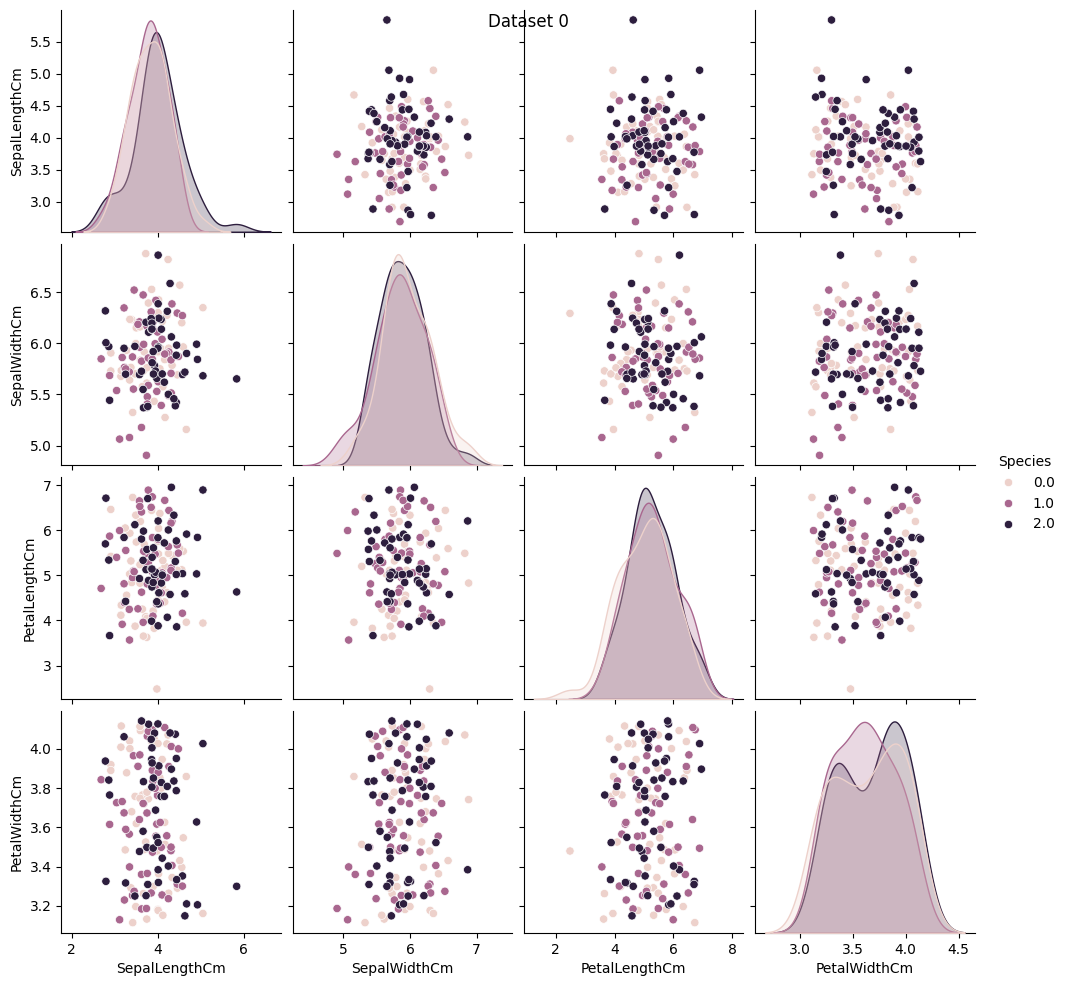

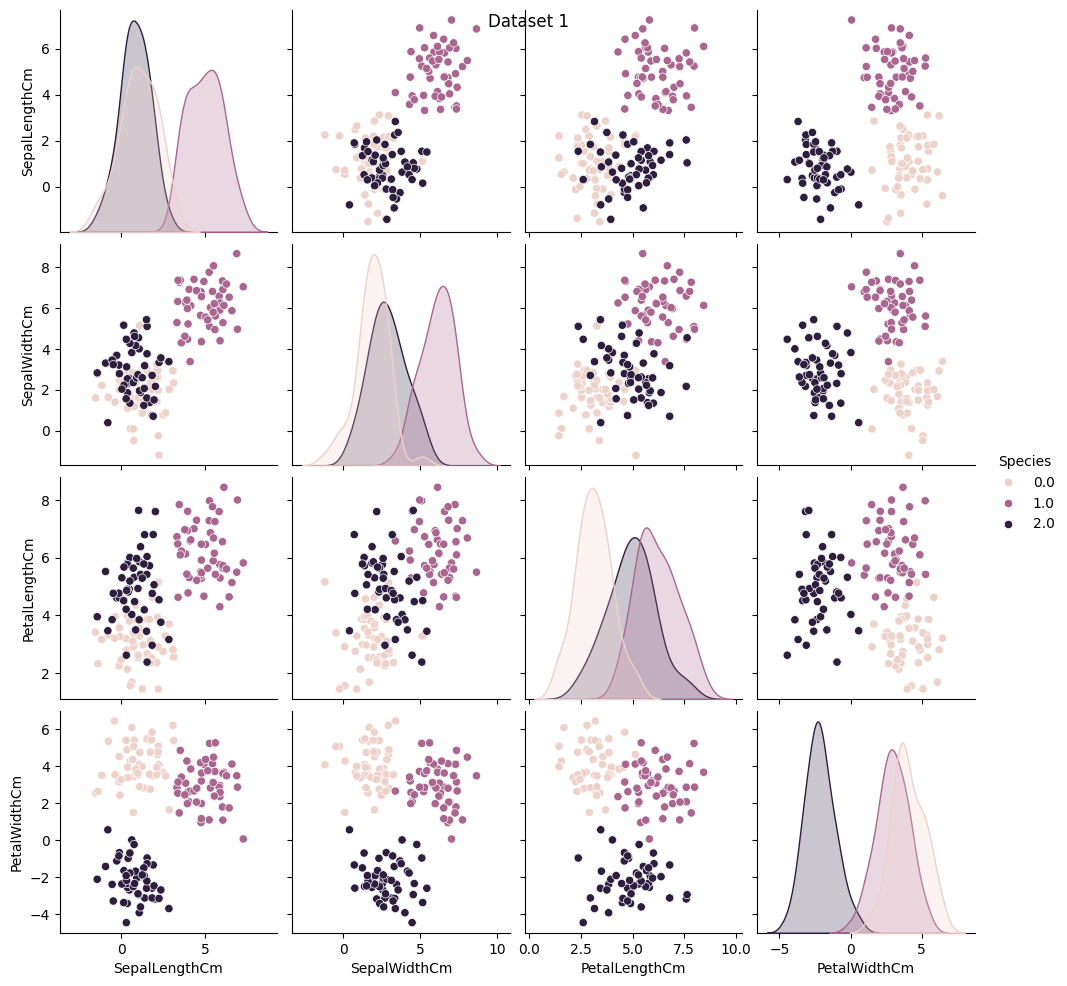

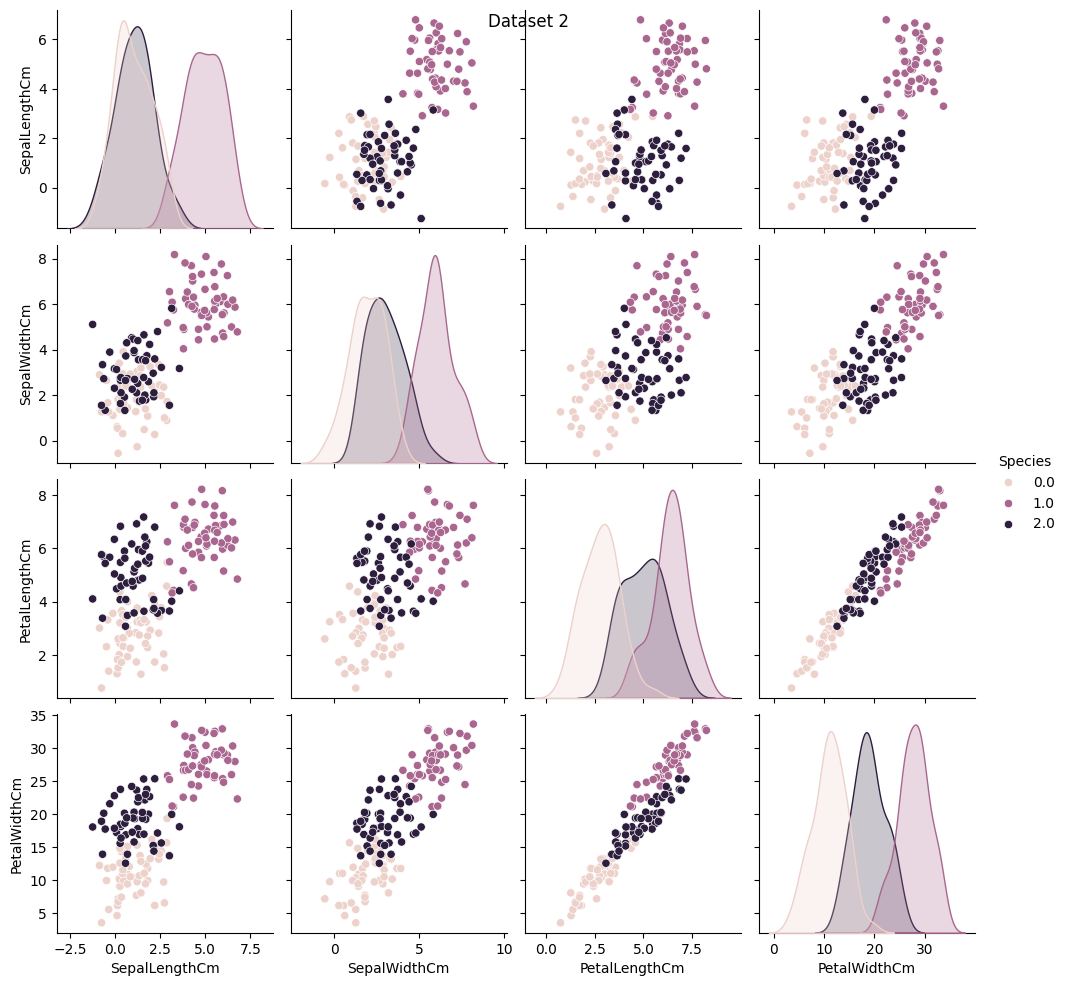

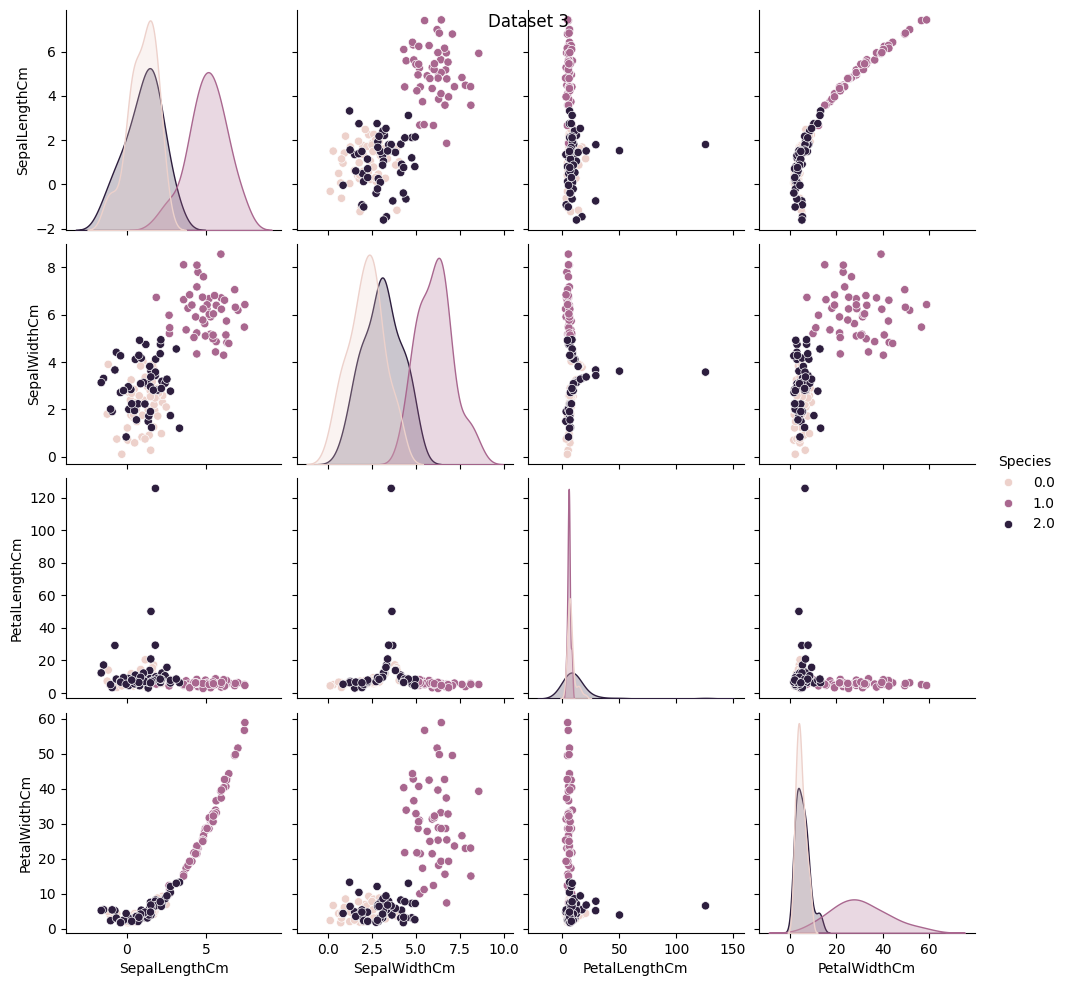

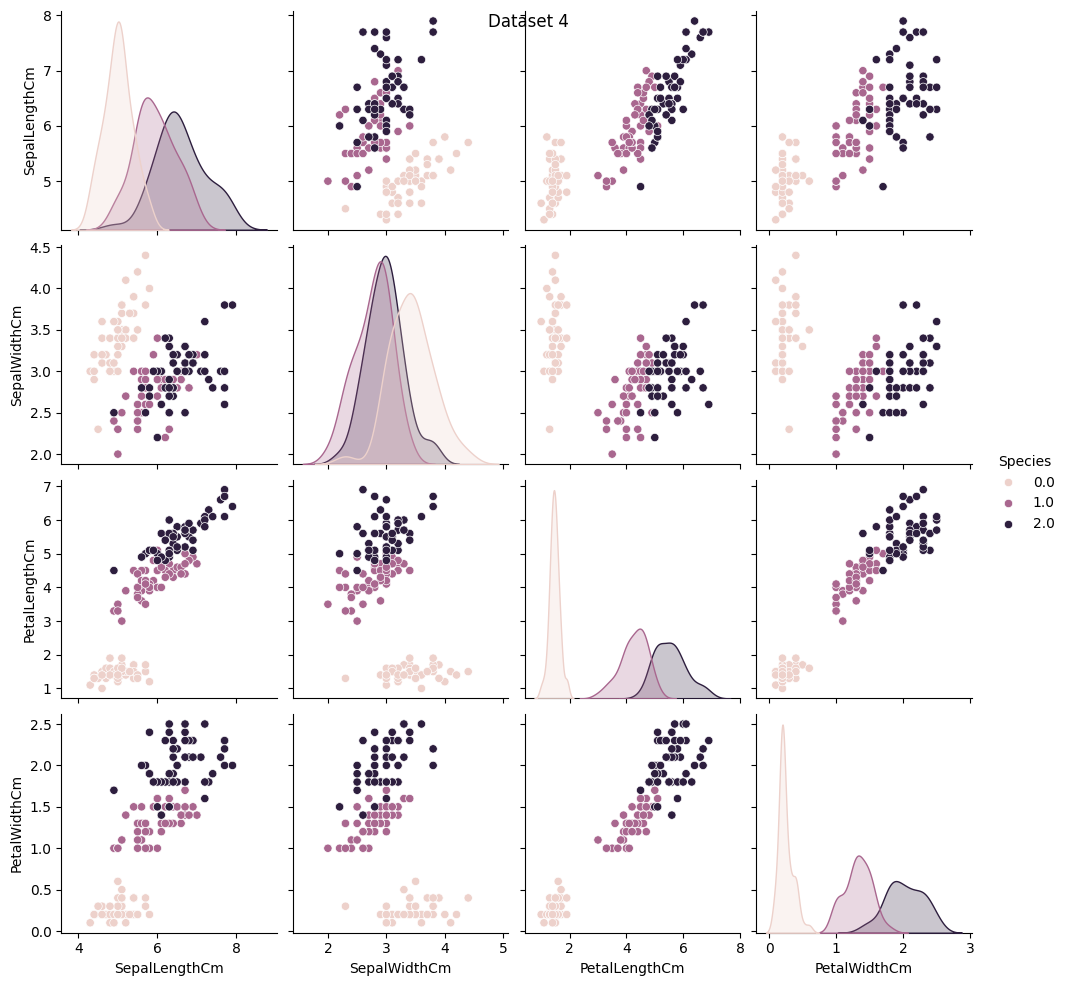

In [12]:
# Asignar nombres a las columnas
df = [df0, df1, df2, df3, df_iris]
for v in df:
    v.columns = columns

# Mostrar los primeros registros de cada dataset
for i, v in enumerate(df):
    print(f"Dataset {i}")
    print(v.head())

# Graficar pairplots para cada dataset
if PLOT:
    for i, v in enumerate(df):
        g = sns.pairplot(data=v, hue='Species')
        g.fig.suptitle(f'Dataset {i}')
        plt.show()
        plt.close()

# Guardar los datasets en archivos CSV
folder = './data'
for i, v in enumerate(df):
    file = 'df' + str(i) + '.csv'
    v.to_csv(folder + '/' + file, index=False)

# Leer los Datasets Guardados

En esta sección, leemos los datasets previamente guardados en archivos CSV. Estos archivos contienen los datos generados en la sección anterior. Leer los datasets desde archivos nos permite mantener una estructura organizada y reproducible en nuestro flujo de trabajo.


In [13]:
dfs = []
folder = './data'
for i in range(5):
    file = 'df' + str(i) + '.csv'
    dfs.append(pd.read_csv(folder + '/' + file))


# Dividir los Datos en Conjuntos de Entrenamiento y Prueba

Para evaluar adecuadamente los métodos de imputación, dividimos cada dataset en conjuntos de entrenamiento y prueba. Esta división nos permitirá entrenar nuestros modelos en un conjunto de datos y evaluar su rendimiento en otro conjunto independiente. Utilizamos una proporción de 85% para entrenamiento y 15% para prueba.


In [15]:
X_trains = []
X_tests = []
y_trains = []
y_tests = []
for df in dfs:
    X = df[NUMERICAL]
    y = df[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

In [21]:
results0 = []
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
#clf = SVC(kernel="linear", C=0.025, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
for X_train, y_train, X_test, y_test in zip(X_trains, y_trains, X_tests, y_tests):
    
    score = cross_val_score(clf, X_train, y_train.squeeze(), scoring= 'accuracy' , cv=cv)
    results0.append(score)

    print(f'Score =  {np.mean(score):5.3f}')

Score =  0.358
Score =  0.980
Score =  0.879
Score =  0.703
Score =  0.924


# Imputación de Valores Nulos

En esta sección, generamos valores nulos en nuestros conjuntos de datos de entrenamiento. La proporción de valores nulos generados es del 20%. 

In [16]:
# Creamos valores nulos
X_trains_missing = []
for X_train, y_train in zip(X_trains, y_trains):
    mask = np.random.choice(a=[np.nan, 1.0], size=X_train.shape, p=[missing_ratio, 1-missing_ratio])
    X_train_aux = X_train * mask
    X_trains_missing.append(X_train_aux)

In [19]:
X_trains[0]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
128,3.862030,6.138167,3.984634,3.944543
131,3.982864,5.657633,4.416831,3.548729
145,4.226835,6.314872,4.071533,3.807964
108,4.908495,5.992449,5.033457,3.626803
143,4.435450,5.884548,5.020805,3.786152
...,...,...,...,...
71,4.086025,5.392710,4.614020,3.497926
106,5.840233,5.652633,4.633265,3.299238
14,3.147539,5.677597,4.116965,4.007876
92,3.761582,5.406487,4.811188,3.364883


In [35]:
X_trains_missing[0]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
128,3.862030,6.138167,NaN,NaN
131,NaN,5.657633,4.416831,3.548729
145,4.226835,6.314872,NaN,3.807964
108,4.908495,5.992449,5.033457,3.626803
143,4.435450,5.884548,5.020805,3.786152
...,...,...,...,...
71,4.086025,5.392710,4.614020,3.497926
106,5.840233,5.652633,4.633265,3.299238
14,3.147539,NaN,4.116965,4.007876
92,3.761582,5.406487,4.811188,NaN


Ahora, aplicamos diferentes técnicas de imputación para llenar estos valores faltantes. Las técnicas que utilizamos incluyen:
1. **[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) (valor constante):** Reemplaza los valores nulos con un valor constante.
2. **SimpleImputer (media):** Reemplaza los valores nulos con la media de la columna.
3. **[KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html):** Utiliza los vecinos más cercanos para imputar los valores nulos.
4. **[IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html):** Utiliza un estimador (en este caso regresión lineal) para completar de manera iterativa los valores nulos.

Evaluamos cada método para ver cuál es más efectivo en nuestros datasets.


In [43]:
df2['SepalLengthCm'].fillna(np.mean(df2['SepalLengthCm']))

0     -0.858898
1      0.694589
2      0.363997
3      0.268793
4      0.692498
         ...   
145    1.692993
146   -0.032832
147    0.952427
148    2.113403
149    2.154685
Name: SepalLengthCm, Length: 150, dtype: float64

Dataset 0
MSE=   0.050, Score= 0.361, Score Previo=0.358


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: 

MSE=   0.050, Score= 0.361, Score Previo=0.358


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: 

MSE=   0.049, Score= 0.360, Score Previo=0.358


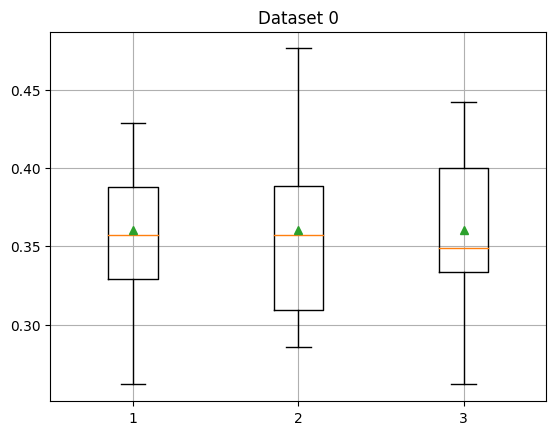

Dataset 1
MSE=   0.632, Score= 0.905, Score Previo=0.980


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: 

MSE=   0.576, Score= 0.918, Score Previo=0.980


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: 

MSE=   0.692, Score= 0.882, Score Previo=0.980


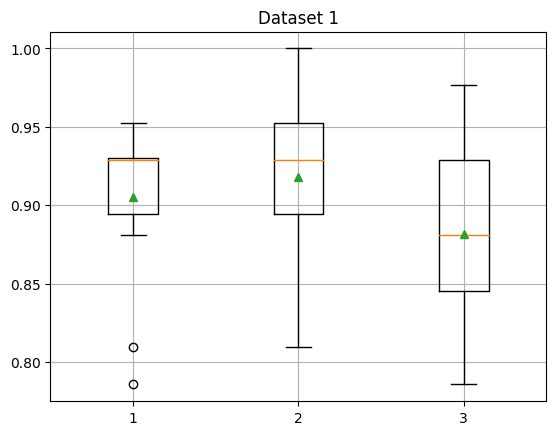

Dataset 2
MSE=   0.252, Score= 0.841, Score Previo=0.879


/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/juanma/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: 

KeyboardInterrupt: 

In [50]:
imputer_idx = 3
for i, (X_train_missing, X_train, y_train, X_test, y_test) in enumerate(zip(X_trains_missing, X_trains, y_trains, X_tests, y_tests)):
    print(f'Dataset {i}')
    results = []
    mses = []

    
    param_grid = [
        [None],
        [None],
        [1, 3, 5, 7, 9, 11],
        [None, 2, 1],
    ]

    for param in param_grid[imputer_idx]:
        if imputer_idx == 0:
            imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=10.0)
        elif imputer_idx == 1:
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        elif imputer_idx == 2:
            imputer = KNNImputer(n_neighbors=param)
        elif imputer_idx == 3:
            imputer = IterativeImputer(n_nearest_features=param,max_iter=80,estimator=LinearRegression())

        clf = DecisionTreeClassifier(random_state=42)
        X_train_imputed = imputer.fit_transform(X_train_missing)
        mse = np.mean((X_train - X_train_imputed)**2)
        pipeline = Pipeline(steps=[
            ('imputer', imputer),
            ('clf', clf)
        ])

        scores = cross_val_score(pipeline, X_train_missing, y_train.squeeze(), scoring='accuracy', cv=cv)
        results.append(scores)
        mses.append(mse)
        print(f'MSE={mse:8.3f}, Score={np.mean(scores):6.3f}, Score Previo={np.mean(results0[i]):5.3f}')

    plt.figure()
    plt.title(f'Dataset {i}')
    plt.boxplot(results, showmeans=True)
    plt.grid()
    plt.show()
    plt.close()

    if PLOT_PAIR:
        df_aux = pd.DataFrame(np.concatenate((X_train_imputed, y_train,), axis=1))
        columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
        df_aux.columns = columns
        sns.pairplot(data=df_aux, hue='Species')
        plt.show()
        plt.close()

# Aplicación de MICE Paso a Paso

El algoritmo MICE (Multiple Imputation by Chained Equations) es una técnica avanzada para la imputación de valores nulos. En esta sección, aplicamos MICE paso a paso. Inicialmente, imputamos cada columna con la media de la columna. Luego, iteramos a través de cada columna, imputando los valores nulos basándonos en un modelo de regresión lineal ajustado a las demás columnas.

Monitoreamos el error cuadrático medio en cada iteración para evaluar la convergencia del proceso de imputación.


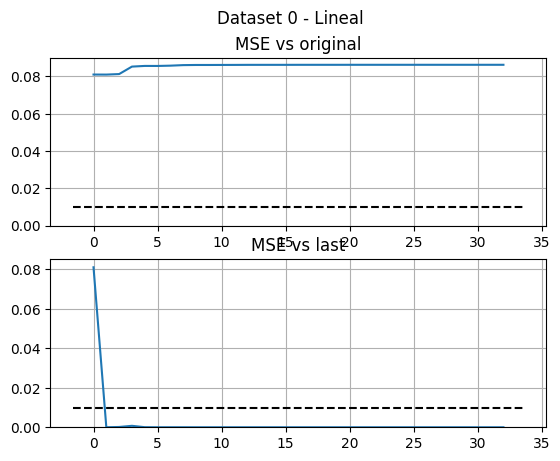

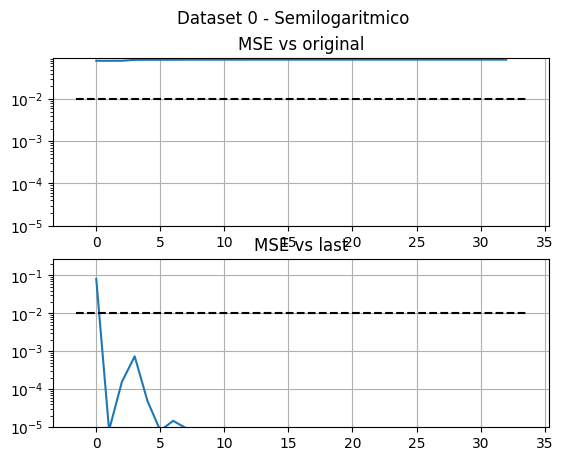

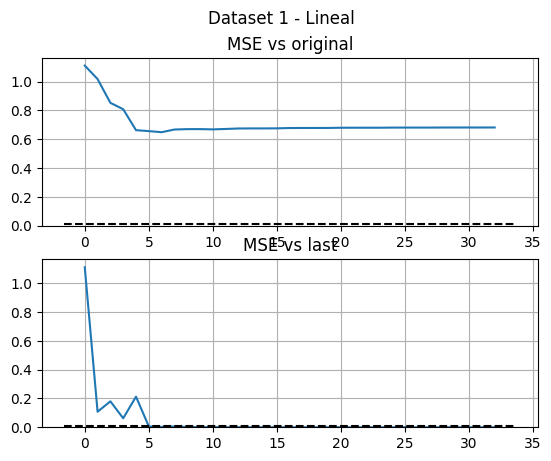

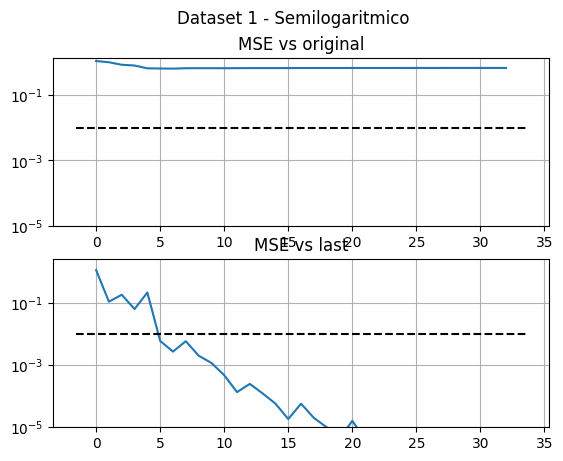

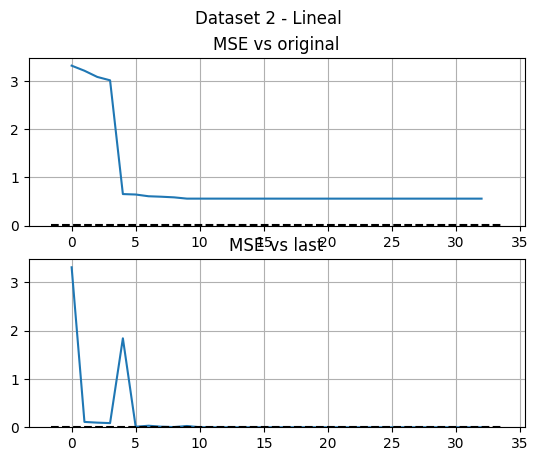

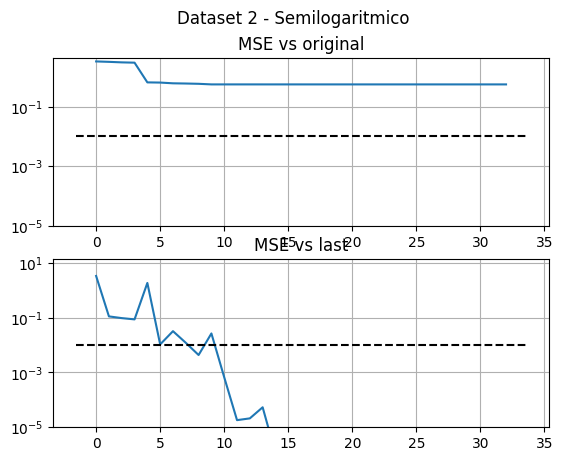

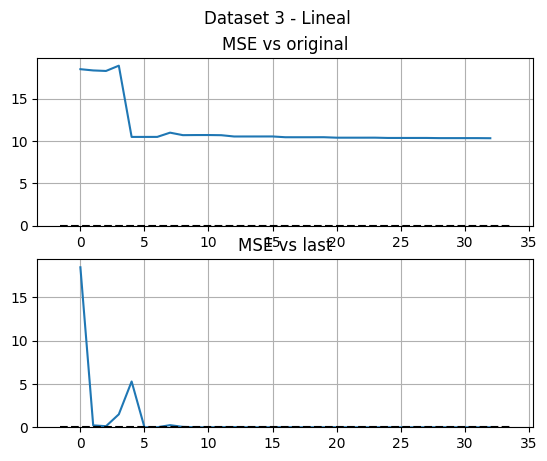

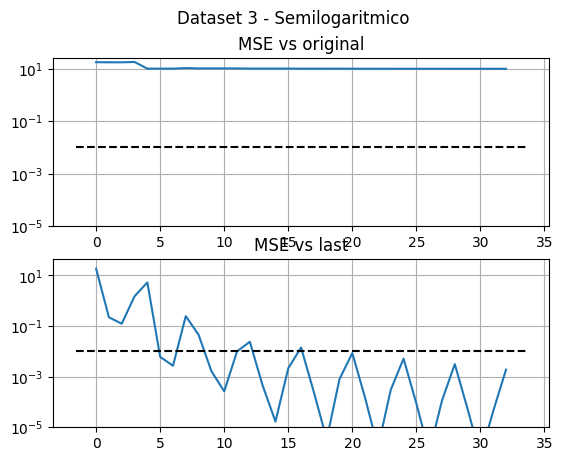

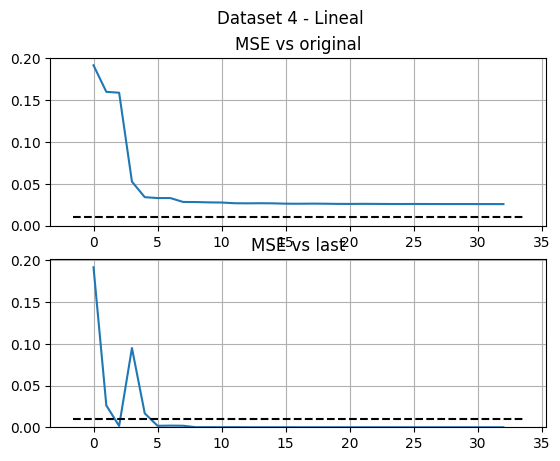

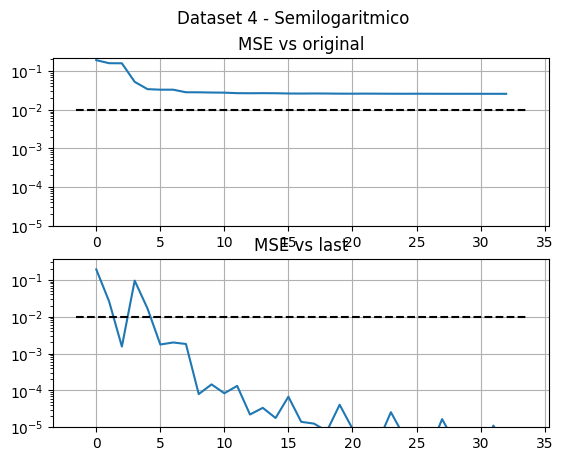

In [37]:
# Función de imputación iterativa
def impute_column(df, col_to_predict, feature_columns):
    nan_rows = np.where(np.isnan(df[col_to_predict]))
    all_rows = np.arange(0, len(df))
    train_rows_idx = np.argwhere(~np.isin(all_rows, nan_rows)).ravel()
    pred_rows_idx = np.argwhere(np.isin(all_rows, nan_rows)).ravel()

    X_train, y_train = df[feature_columns].iloc[train_rows_idx], df[col_to_predict].iloc[train_rows_idx]
    X_pred = df[feature_columns].iloc[pred_rows_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    df.loc[pred_rows_idx, col_to_predict] = model.predict(X_pred)
    return df

# Aplicación de MICE paso a paso
for df_idx, df in enumerate(dfs):
    X = df[NUMERICAL]
    y = df[TARGET]
    X_missing = []
    mask = np.random.choice(a=[np.nan, 1.0], size=X.shape, p=[missing_ratio, 1-missing_ratio])
    X_missing = X * mask

    df_orig = pd.DataFrame(X)
    df_missing = pd.DataFrame(X_missing)
    df_0 = df_missing.copy()
    for col in NUMERICAL:
        df_0.loc[df_0[col].isna(), col] = df_0[col].mean()
    dfs = [df_0]
    mses_vs_last = [np.mean((df_0 - df_orig)**2)]
    mses_vs_orig = [np.mean((df_0 - df_orig)**2)]
    for step in range(8):
        for col in NUMERICAL:
            tmp_feature_cols = copy(NUMERICAL)
            tmp_feature_cols.remove(col)
            df_last = dfs[-1]
            df_aux = df_last.copy()
            df_aux.loc[df_missing[col].isna(), col] = np.nan
            df_imputed = impute_column(df_aux, col, tmp_feature_cols)
            dfs.append(df_imputed)
            mses_vs_last.append(np.mean((df_imputed - df_last)**2))
            mses_vs_orig.append(np.mean((df_imputed - df_orig)**2))

    fig, axs = plt.subplots(2, 1)
    fig.suptitle(f'Dataset {df_idx} - Lineal')
    axs[0].plot(mses_vs_orig)
    axs[0].title.set_text('MSE vs original')
    axs[1].plot(mses_vs_last)
    axs[1].title.set_text('MSE vs last')
    xlim = axs[0].get_xlim()
    axs[0].hlines(0.01, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    xlim = axs[1].get_xlim()
    axs[1].hlines(0.01, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    axs[0].set_ylim(0, None)
    axs[1].set_ylim(0, None)
    axs[0].grid()
    axs[1].grid()

    fig, axs = plt.subplots(2, 1)
    fig.suptitle(f'Dataset {df_idx} - Semilogaritmico')
    axs[0].semilogy(mses_vs_orig)
    axs[0].title.set_text('MSE vs original')
    axs[1].semilogy(mses_vs_last)
    axs[1].title.set_text('MSE vs last')
    xlim = axs[0].get_xlim()
    axs[0].hlines(0.01, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    xlim = axs[1].get_xlim()
    axs[1].hlines(0.01, xmin=xlim[0], xmax=xlim[1], color='black', linestyle='dashed')
    axs[0].set_ylim(1e-5, None)
    axs[1].set_ylim(1e-5, None)
    axs[0].grid()
    axs[1].grid()

plt.show()